# Capstone Project - Short Answer Grading

## ShortAnswerGrading V2 Data and Modeling

In [2]:
import pandas as pd
import os
import numpy as np

# should be the name of directory you created to save your features data
data_dir = 'data/sag2'

# Setup AWS

In [3]:
import boto3
import sagemaker

# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

ModuleNotFoundError: No module named 'boto3'

In [118]:
# set prefix, a descriptive name for a directory  
prefix = 'sagemaker/short_answer'

# upload all data to S3
train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'train_xgb.csv'), key_prefix=prefix)
validation_location = sagemaker_session.upload_data(os.path.join(data_dir, 'validate_xgb.csv'), key_prefix=prefix)

s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=validation_location, content_type='csv')


## Analyzing Source Data

In [58]:
raw_data = pd.read_csv(os.path.join(data_dir, "answers.csv"), dtype={'id':str})
train_data = pd.read_csv(os.path.join(data_dir, "train_xgb.csv"), header=None, names=None)
validate_data = pd.read_csv(os.path.join(data_dir, "validate_xgb.csv"), header=None, names=None)
test_data = pd.read_csv(os.path.join(data_dir, "test.csv"), header=None, names=None)
vocab = pd.read_csv(os.path.join(data_dir, "vocab.csv"), header=None, names=None)

In [116]:
print(len(train_data))
print(len(validate_data))

1200
509


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2442 entries, 0 to 2441
Data columns (total 4 columns):
id         2442 non-null float64
answer     2442 non-null object
score      2442 non-null float64
correct    2442 non-null float64
dtypes: float64(3), object(1)
memory usage: 76.4+ KB


In [6]:
len(vocab)

2648

In [59]:
raw_data['answer_length'] = raw_data['answer'].apply(lambda x: len(x))
raw_data

,id,answer,score,correct,answer_length
0,1.1,High risk problems are address in the prototyp...,3.5,0.0,191
1,1.1,To simulate portions of the desired final prod...,5.0,1.0,202
2,1.1,A prototype program simulates the behaviors of...,4.0,1.0,116
3,1.1,Defined in the Specification phase a prototype...,5.0,1.0,251
4,1.1,It is used to let the users have a first idea ...,3.0,0.0,229
5,1.1,To find problem and errors in a program before...,2.0,0.0,62
6,1.1,To address major issues in the creation of the...,2.5,0.0,173
7,1.1,you can break the whole program into prototype...,5.0,1.0,94
8,1.1,To provide an example or model of how the fini...,3.5,0.0,211
9,1.1,Simulating the behavior of only a portion of t...,5.0,1.0,74


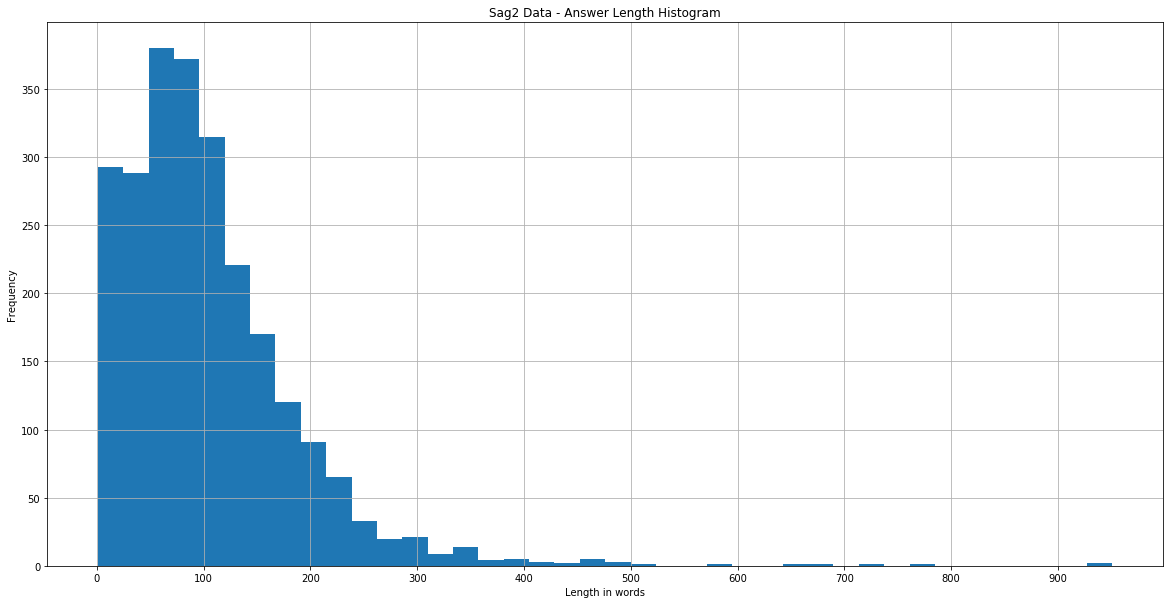

In [27]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(20,10))
plt.xlabel('Length in words')
plt.ylabel('Frequency')
plt.title('Sag2 Data - Answer Length Histogram')
plt.hist(raw_data['answer_length'].values, bins=40)
plt.xticks(np.arange(0, 1000, step=100))
plt.grid(True)
plt.show()

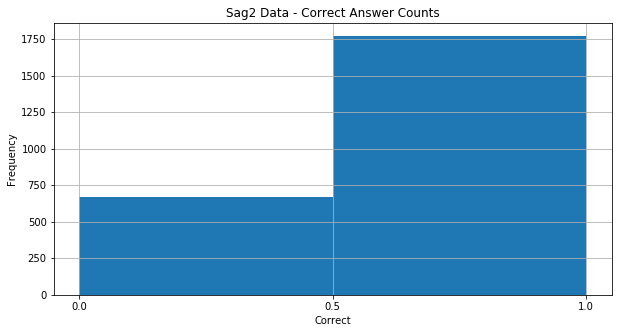

In [100]:
plt.figure(figsize=(10,5))
plt.xlabel('Correct')
plt.ylabel('Frequency')
plt.title('Sag2 Data - Correct Answer Counts')
plt.xticks(np.arange(0, 2, step=0.5))
plt.grid(True)
plt.hist(raw_data['correct'],bins=2)
plt.show()

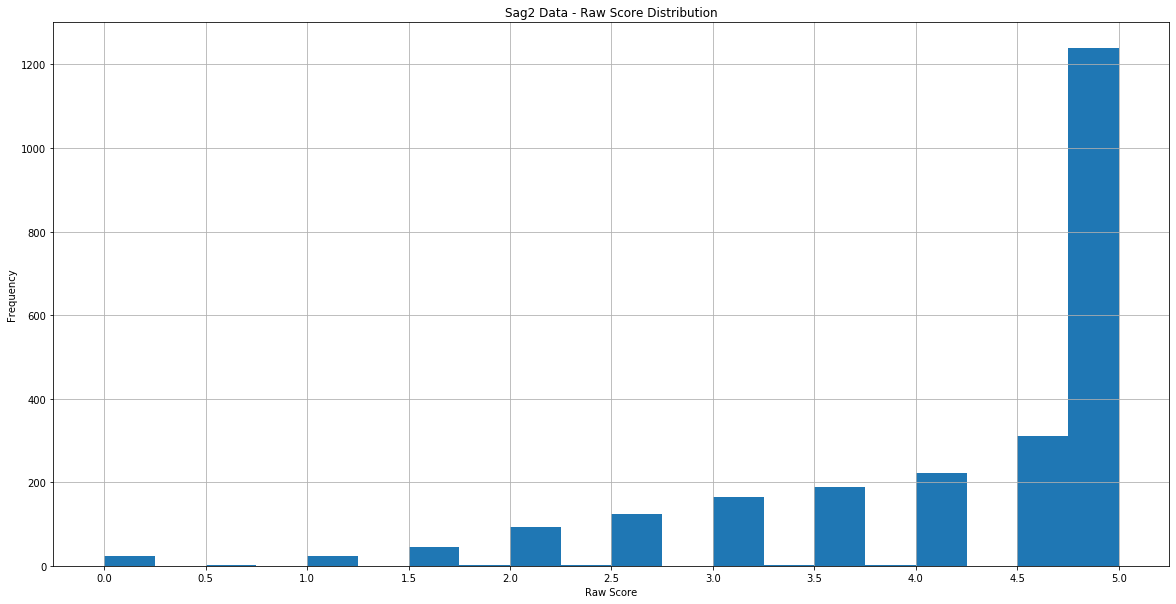

In [102]:
scores = raw_data['score']
plt.figure(figsize=(20,10))
plt.xlabel('Raw Score')
plt.ylabel('Frequency')
plt.title('Sag2 Data - Raw Score Distribution')
plt.hist(scores.values, bins=20)
plt.xticks(np.arange(0, 5.5, step=0.5))
plt.grid(True)
plt.show()

In [45]:
raw_data.groupby('score')['score'].count()

score
0.000      24
0.500       3
1.000      23
1.500      46
1.750       1
2.000      93
2.250       2
2.500     125
3.000     164
3.250       1
3.500     187
3.625       1
3.750       1
4.000     220
4.125       2
4.500     310
4.750       1
5.000    1238
Name: score, dtype: int64

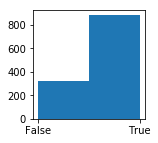

In [132]:
plt.hist(train_data[0],bins=2)
plt.xticks(np.arange(2), ['False', 'True'])
plt.rcParams["figure.figsize"] = [2,2]
plt.show()

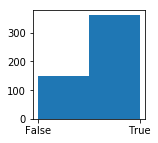

In [133]:
plt.hist(validate_data[0],bins=2)
plt.xticks(np.arange(2), ['False', 'True'])
plt.rcParams["figure.figsize"] = [2,2]
plt.show()

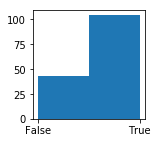

In [134]:
plt.hist(test_data[0],bins=2)
plt.xticks(np.arange(2), ['False', 'True'])
plt.rcParams["figure.figsize"] = [2,2]
plt.show()

# Training Basic Model

In [15]:
# We need to retrieve the location of the container which is provided by Amazon for using XGBoost.
# As a matter of convenience, the training and inference code both use the same container.
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost')

In [119]:
estimator = sagemaker.estimator.Estimator(container, # The location of the container we wish to use
                                    role,                                    # What is our current IAM Role
                                    train_instance_count=1,                  # How many compute instances
                                    train_instance_type='ml.m4.xlarge',      # What kind of compute instances
                                    output_path='s3://{}/{}/output'.format(sagemaker_session.default_bucket(), prefix),
                                    sagemaker_session=sagemaker_session)

estimator.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silence=1,
                        objective='binary:logistic',
                        early_stopping_rounds=50,
                        num_round=4000)

In [122]:
%%time
# Train estimator on S3 training data
estimator.fit({'train': s3_input_train, 'validation': s3_input_validation})

2019-07-02 13:50:30 Starting - Starting the training job...
2019-07-02 13:50:31 Starting - Launching requested ML instances......
2019-07-02 13:51:34 Starting - Preparing the instances for training......
2019-07-02 13:52:42 Downloading - Downloading input data...
2019-07-02 13:53:16 Training - Downloading the training image..
Arguments: train
[2019-07-02:13:53:37:INFO] Running standalone xgboost training.
[2019-07-02:13:53:37:INFO] File size need to be processed in the node: 1.23mb. Available memory size in the node: 8470.11mb
[2019-07-02:13:53:37:INFO] Determined delimiter of CSV input is ','
[13:53:37] S3DistributionType set as FullyReplicated
[13:53:37] 1200x176 matrix with 211200 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-07-02:13:53:37:INFO] Determined delimiter of CSV input is ','
[13:53:37] S3DistributionType set as FullyReplicated
[13:53:37] 509x176 matrix with 89584 entries loaded from /opt/ml/input/data/validation?format=csv&label

In [123]:
estimator._current_job_name

'xgboost-2019-07-02-13-50-30-261'

# Hypertuning Model

In [137]:
# First, make sure to import the relevant objects used to construct the tuner
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = estimator, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:rmse', # The metric used to compare trained models.
                                               objective_type = 'Minimize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 18, # The total number of models to train
                                               max_parallel_jobs = 6, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 12),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })


In [140]:
# tf_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})
xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [141]:
xgb_hyperparameter_tuner.wait()

......................................................................................................................................!


In [144]:
training_job_name = xgb_hyperparameter_tuner.best_training_job()
print(training_job_name)

xgboost-190702-1956-017-2473c488


In [145]:
# training_job_name = 'xgboost-2019-07-02-13-50-30-261'
estimator = sagemaker.estimator.Estimator.attach(training_job_name)

2019-07-02 20:06:49 Starting - Preparing the instances for training
2019-07-02 20:06:49 Downloading - Downloading input data
2019-07-02 20:06:49 Training - Training image download completed. Training in progress.
2019-07-02 20:06:49 Uploading - Uploading generated training model
2019-07-02 20:06:49 Completed - Training job completedArguments: train
[2019-07-02:20:06:38:INFO] Running standalone xgboost training.
[2019-07-02:20:06:38:INFO] Setting up HPO optimized metric to be : rmse
[2019-07-02:20:06:38:INFO] File size need to be processed in the node: 1.23mb. Available memory size in the node: 8459.77mb
[2019-07-02:20:06:38:INFO] Determined delimiter of CSV input is ','
[20:06:38] S3DistributionType set as FullyReplicated
[20:06:38] 1200x176 matrix with 211200 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-07-02:20:06:38:INFO] Determined delimiter of CSV input is ','
[20:06:38] S3DistributionType set as FullyReplicated
[20:06:38] 509x176 matrix

In [149]:
print(estimator.hyperparameters())

{'_tuning_objective_metric': 'validation:rmse', 'early_stopping_rounds': '50', 'eta': '0.054923833286676146', 'gamma': '3.0417882183103795', 'max_depth': '10', 'min_child_weight': '2', 'num_round': '4000', 'objective': 'binary:logistic', 'silence': '1', 'subsample': '0.8536558502241701'}


In [150]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

--------------------------------------------------------------------------------------------------------------------------!

## Load and Evaluate Test Data

In [151]:
import numpy as np
def evaluate(predictor, test_features, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # rounding and squeezing array
    predictions = []
    for x in test_features:
        x = ','.join(str(val) for val in x).encode('utf-8') 
        pred = float(predictor.predict(x))
        predictions.append(pred)
        # print(x)

    raw_preds = np.array(predictions)    
    print(raw_preds)
    
    test_preds = raw_preds
    # Normalized to range 0 to 1
    min_pred = test_preds.min()
    max_pred = test_preds.max()
    print(f"Min pred: {min_pred} Max pred: {max_pred}")
    test_y_preds = (test_preds - min_pred) / (max_pred - min_pred)
    test_preds = np.round(test_y_preds)  
    print(test_preds)
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # print metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actuals'], colnames=['predictions']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return tp, fp, fn, tn, precision, recall, accuracy, raw_preds

In [152]:
test_data = pd.read_csv(os.path.join(data_dir, "test.csv"), header=None, names=None)
test_y = test_data.iloc[:, 0].values
test_x = test_data.iloc[:, 1:].values
print(test_y)
print(test_x)

[0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1.
 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 1.]
[[4.100e+01 1.740e+02 8.230e+02 ... 0.000e+00 0.000e+00 0.000e+00]
 [9.000e+00 7.000e+01 3.960e+02 ... 0.000e+00 0.000e+00 0.000e+00]
 [7.700e+01 1.307e+03 8.980e+02 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [2.400e+01 1.770e+03 1.685e+03 ... 0.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 1.200e+01 2.300e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.800e+01 9.090e+02 1.747e+03 ... 0.000e+00 0.000e+00 0.000e+00]]


In [153]:
x = ','.join(str(val) for val in test_x[-1]).encode('utf-8')
print(x)

b'28.0,909.0,1747.0,1770.0,1561.0,567.0,147.0,1737.0,909.0,1937.0,1770.0,21.0,816.0,909.0,898.0,970.0,147.0,933.0,909.0,1779.0,816.0,909.0,947.0,1777.0,909.0,754.0,1805.0,1770.0,1788.0,567.0,147.0,875.0,909.0,833.0,1770.0,1520.0,1297.0,1937.0,1501.0,1805.0,1770.0,693.0,22.0,567.0,147.0,1637.0,1195.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'


In [154]:
pred = predictor.predict(x)
print(float(pred))
print(test_y[-1])

0.780285716057
1.0


In [155]:
# Second: calculate the test accuracy
tp, fp, fn, tn, precision, recall, accuracy, test_y_preds = evaluate(predictor, test_x, test_y)

## print out the array of predicted and true labels, if you want
results = pd.concat([pd.DataFrame(test_y_preds), pd.DataFrame(np.round(test_y_preds)), pd.DataFrame(test_y)], axis=1)
results.columns = ['raw_predicted','predicted','actual']
incorrect_results = results[results['predicted'] != results['actual']]
print(incorrect_results)

[0.32678574 0.79644269 0.77557814 0.38392627 0.90085679 0.86234808
 0.81323242 0.9275825  0.43325192 0.79614121 0.81789666 0.78181314
 0.56183892 0.83131528 0.86051196 0.59374124 0.64796621 0.92559397
 0.88101071 0.64151406 0.58214283 0.80274528 0.84412384 0.7797907
 0.70234853 0.39340898 0.87180525 0.8669517  0.89111131 0.8191275
 0.83048224 0.91622072 0.54515237 0.87353998 0.31071445 0.88207853
 0.74594939 0.64250892 0.894346   0.36175376 0.60943013 0.59341592
 0.81020766 0.9180795  0.90193707 0.63258427 0.89641726 0.6000554
 0.78623253 0.91896486 0.66845024 0.83035636 0.92030847 0.32905725
 0.44934645 0.24648586 0.80238605 0.64388496 0.86462373 0.83491057
 0.50751072 0.46339455 0.6935935  0.63766003 0.88229996 0.84839934
 0.85528398 0.87278527 0.90288305 0.353811   0.88230991 0.8473922
 0.6591298  0.52620828 0.58381915 0.23997389 0.65244907 0.89645046
 0.88434255 0.74354488 0.88537091 0.79744244 0.83493567 0.60971862
 0.91204321 0.80908322 0.69283193 0.87814057 0.90142453 0.9026593


In [156]:
predictor.delete_endpoint()